## Example notebook for inferring RPE cell cycle trajectories

In [1]:
import os
import pandas as pd
import scanpy as sc
import sys
sys.path.append('..')
import delve_benchmark

adata_directory = '../data/Zenodo' ## https://zenodo.org/records/10105826
adata = sc.read_h5ad(os.path.join(adata_directory, 'adata_RPE.h5ad'))

### Perform DELVE feature selection

In [2]:
n_selected = 30
k = 10
trial = 0

feature_directory = os.path.join('../data', 'RPE', 'predicted_features')
delve_benchmark.pp.make_directory(feature_directory)

fs = delve_benchmark.tl.fs(adata = adata, fs_method = delve_benchmark.tl.run_delve_fs, fs_method_params = {'num_subsamples': 1000, 'n_clusters': 5, 'k': k, 'n_random_state': 10, 'return_modules': True})
delta_mean, modules, delve_genes = fs.select()

##save 
delve_genes.to_csv(os.path.join(feature_directory, f'delve_fs_trial{trial}.csv'))
delve_genes = delve_genes.index[:n_selected]
delta_mean.to_csv(os.path.join(feature_directory, f'delta_mean_trial{trial}.csv'))
modules.to_csv(os.path.join(feature_directory, f'modules_trial{trial}.csv'))

INFO:root:Step 1: identifying dynamic feature modules
INFO:root:estimating feature dynamics
performing subsampling: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]
clustering features and performing gene-wise permutation testing: 100%|██████████| 10/10 [00:22<00:00,  2.23s/it]
INFO:root:identified 1 dynamic cluster(s)
INFO:root:Step 2: performing feature selection


### Plot core cell cycle module identified by DELVE

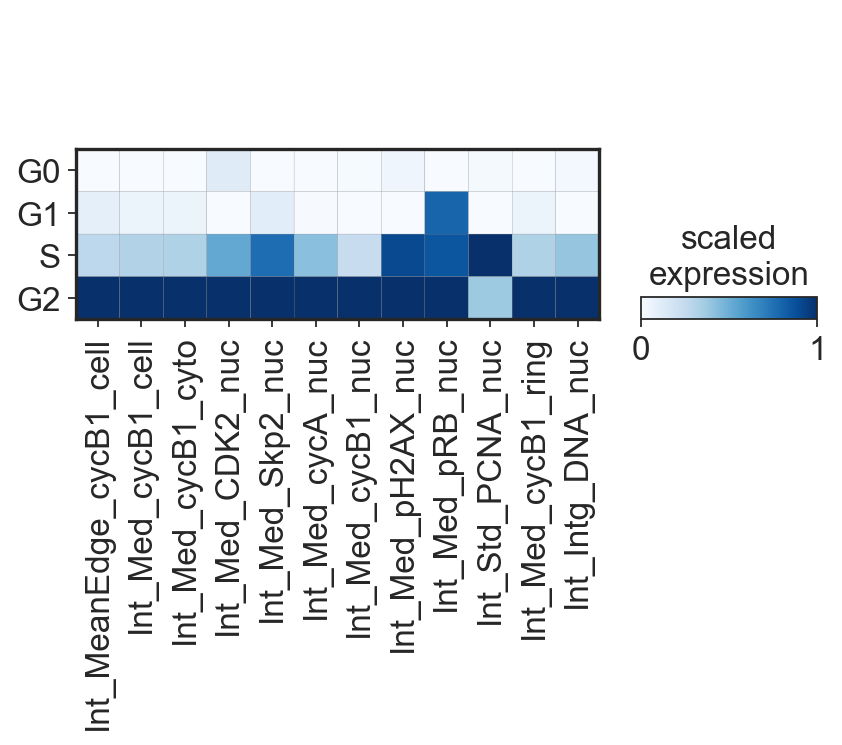

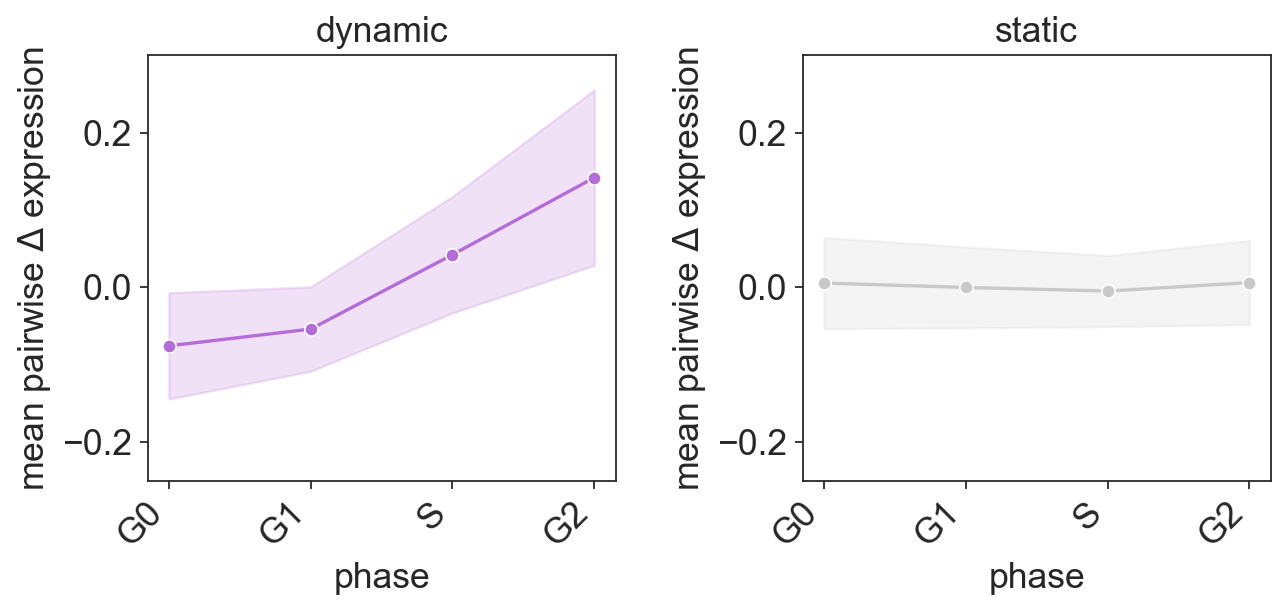

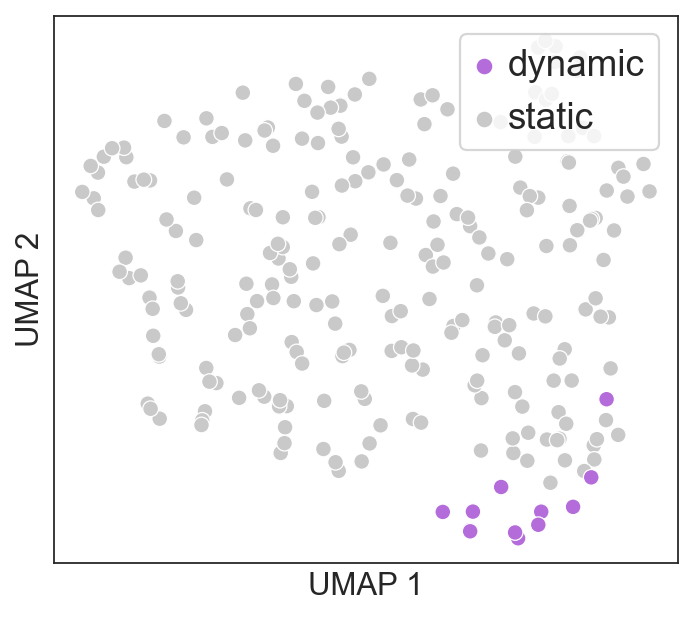

In [3]:
seed_directory = os.path.join('../figures', 'RPE', 'seed')

delve_benchmark.pl.plot_seed(adata_directory = adata_directory, feature_directory = feature_directory, adata_name = 'adata_RPE', labels_key = 'phase',
            save_directory = seed_directory, filename_save = 'RPE', m_order = ['G0', 'G1', 'S', 'G2'], trial = trial, ylim = [-0.25,0.3])


### Perform feature selection using alternative strategies

In [4]:
n_selected = 30
trial = 0
fs_method_list = [[delve_benchmark.tl.seed_features, {'num_subsamples': 1000, 'n_clusters': 5, 'k': 10, 'n_random_state': 10}],
                    [delve_benchmark.tl.all_features, {}],
                    [delve_benchmark.tl.random_features, {}],
                    [delve_benchmark.tl.random_forest, {'n_splits': 10, 'labels_key': 'phase'}],
                    [delve_benchmark.tl.laplacian_score_fs, {'k': 10}],
                    [delve_benchmark.tl.neighborhood_variance_fs, {}],
                    [delve_benchmark.tl.mcfs_fs, {'k': 10, 'n_selected_features': 30, 'n_clusters':4}],
                    [delve_benchmark.tl.variance_score, {}],
                    [delve_benchmark.tl.hvg, {'n_top_genes': n_selected, 'log': True}],
                    [delve_benchmark.tl.scmer_fs, {'k': 10, 'n_pcs': 50}],
                    [delve_benchmark.tl.hotspot_fs, {'k': 10, 'n_pcs': 50, 'model':'danb'}],
                    [delve_benchmark.tl.run_delve_fs, {'num_subsamples': 1000, 'n_clusters': 5, 'k': 10, 'return_modules':True, 'n_random_state': 10, 'random_state': 0}]]


for fs_method, fs_method_params in fs_method_list:
    fs_name = fs_method.__name__
    fs = delve_benchmark.tl.fs(adata = adata, fs_method = fs_method, fs_method_params = fs_method_params)

    if fs_name == 'run_delve_fs':
        delta_mean, modules, ranked_features = fs.select()
        ranked_features = ranked_features[:n_selected]
        ranked_features.to_csv(os.path.join(feature_directory, f'delve_fs_trial{trial}.csv'))
        delta_mean.to_csv(os.path.join(feature_directory, f'delta_mean_trial{trial}.csv'))
        modules.to_csv(os.path.join(feature_directory, f'modules_trial{trial}.csv'))
    elif fs_name == 'all_features':
        ranked_features = fs.select()
        ranked_features = pd.DataFrame(ranked_features)
        ranked_features.to_csv(os.path.join(feature_directory, f'{fs_name}.csv')) #all features
    else:
        ranked_features = fs.select()
        ranked_features = pd.DataFrame(ranked_features[:n_selected])
        ranked_features.to_csv(os.path.join(feature_directory, f'{fs_name}.csv')) #all features
    print(f'{fs_name}: selected {len(ranked_features)} features')

INFO:root:estimating feature dynamics
performing subsampling: 100%|██████████| 1/1 [00:04<00:00,  5.00s/it]
clustering features and performing gene-wise permutation testing: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it]
INFO:root:identified 1 dynamic cluster(s)


seed_features: selected 12 features
all_features: selected 241 features
random_features: selected 30 features
random_forest: selected 30 features
laplacian_score_fs: selected 30 features
constructed a minimally connected kNN graph with 4 neighbors
neighborhood_variance_fs: selected 30 features
mcfs_fs: selected 30 features
variance_score: selected 30 features
hvg: selected 30 features
Calculating distance matrix and scaling factors...
Computing pairwise distances...
Computing P-values for point 0 of 2759...
Computing P-values for point 500 of 2759...
Computing P-values for point 1000 of 2759...
Computing P-values for point 1500 of 2759...
Computing P-values for point 2000 of 2759...
Computing P-values for point 2500 of 2759...
Mean value of sigma: 0.233914
Done. Elapsed time: 21.34 seconds. Total: 21.34 seconds.
Creating model without batches...
Optimizing using OWLQN (because lasso is nonzero)...
0 loss (before this step): 2.57513427734375 Nonzero (after): 129 Elapsed time: 8.25 secon

100%|██████████| 241/241 [00:00<00:00, 940.32it/s]
INFO:root:Step 1: identifying dynamic feature modules


hotspot_fs: selected 30 features


INFO:root:estimating feature dynamics
performing subsampling: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
clustering features and performing gene-wise permutation testing: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]
INFO:root:identified 1 dynamic cluster(s)
INFO:root:Step 2: performing feature selection


run_delve_fs: selected 30 features


### Plot trajectories using PHATE

Calculating PHATE...
  Running PHATE on 2759 cells and 30 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.19 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.23 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.24 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.58 seconds.
  Calculated landmark operator in 7.21 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.40 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 12.87 seconds.
Calculated PHATE in 20.73 seconds.
Calculating PHATE...
  Running PHATE on 2759 cells and 30 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.20 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffu

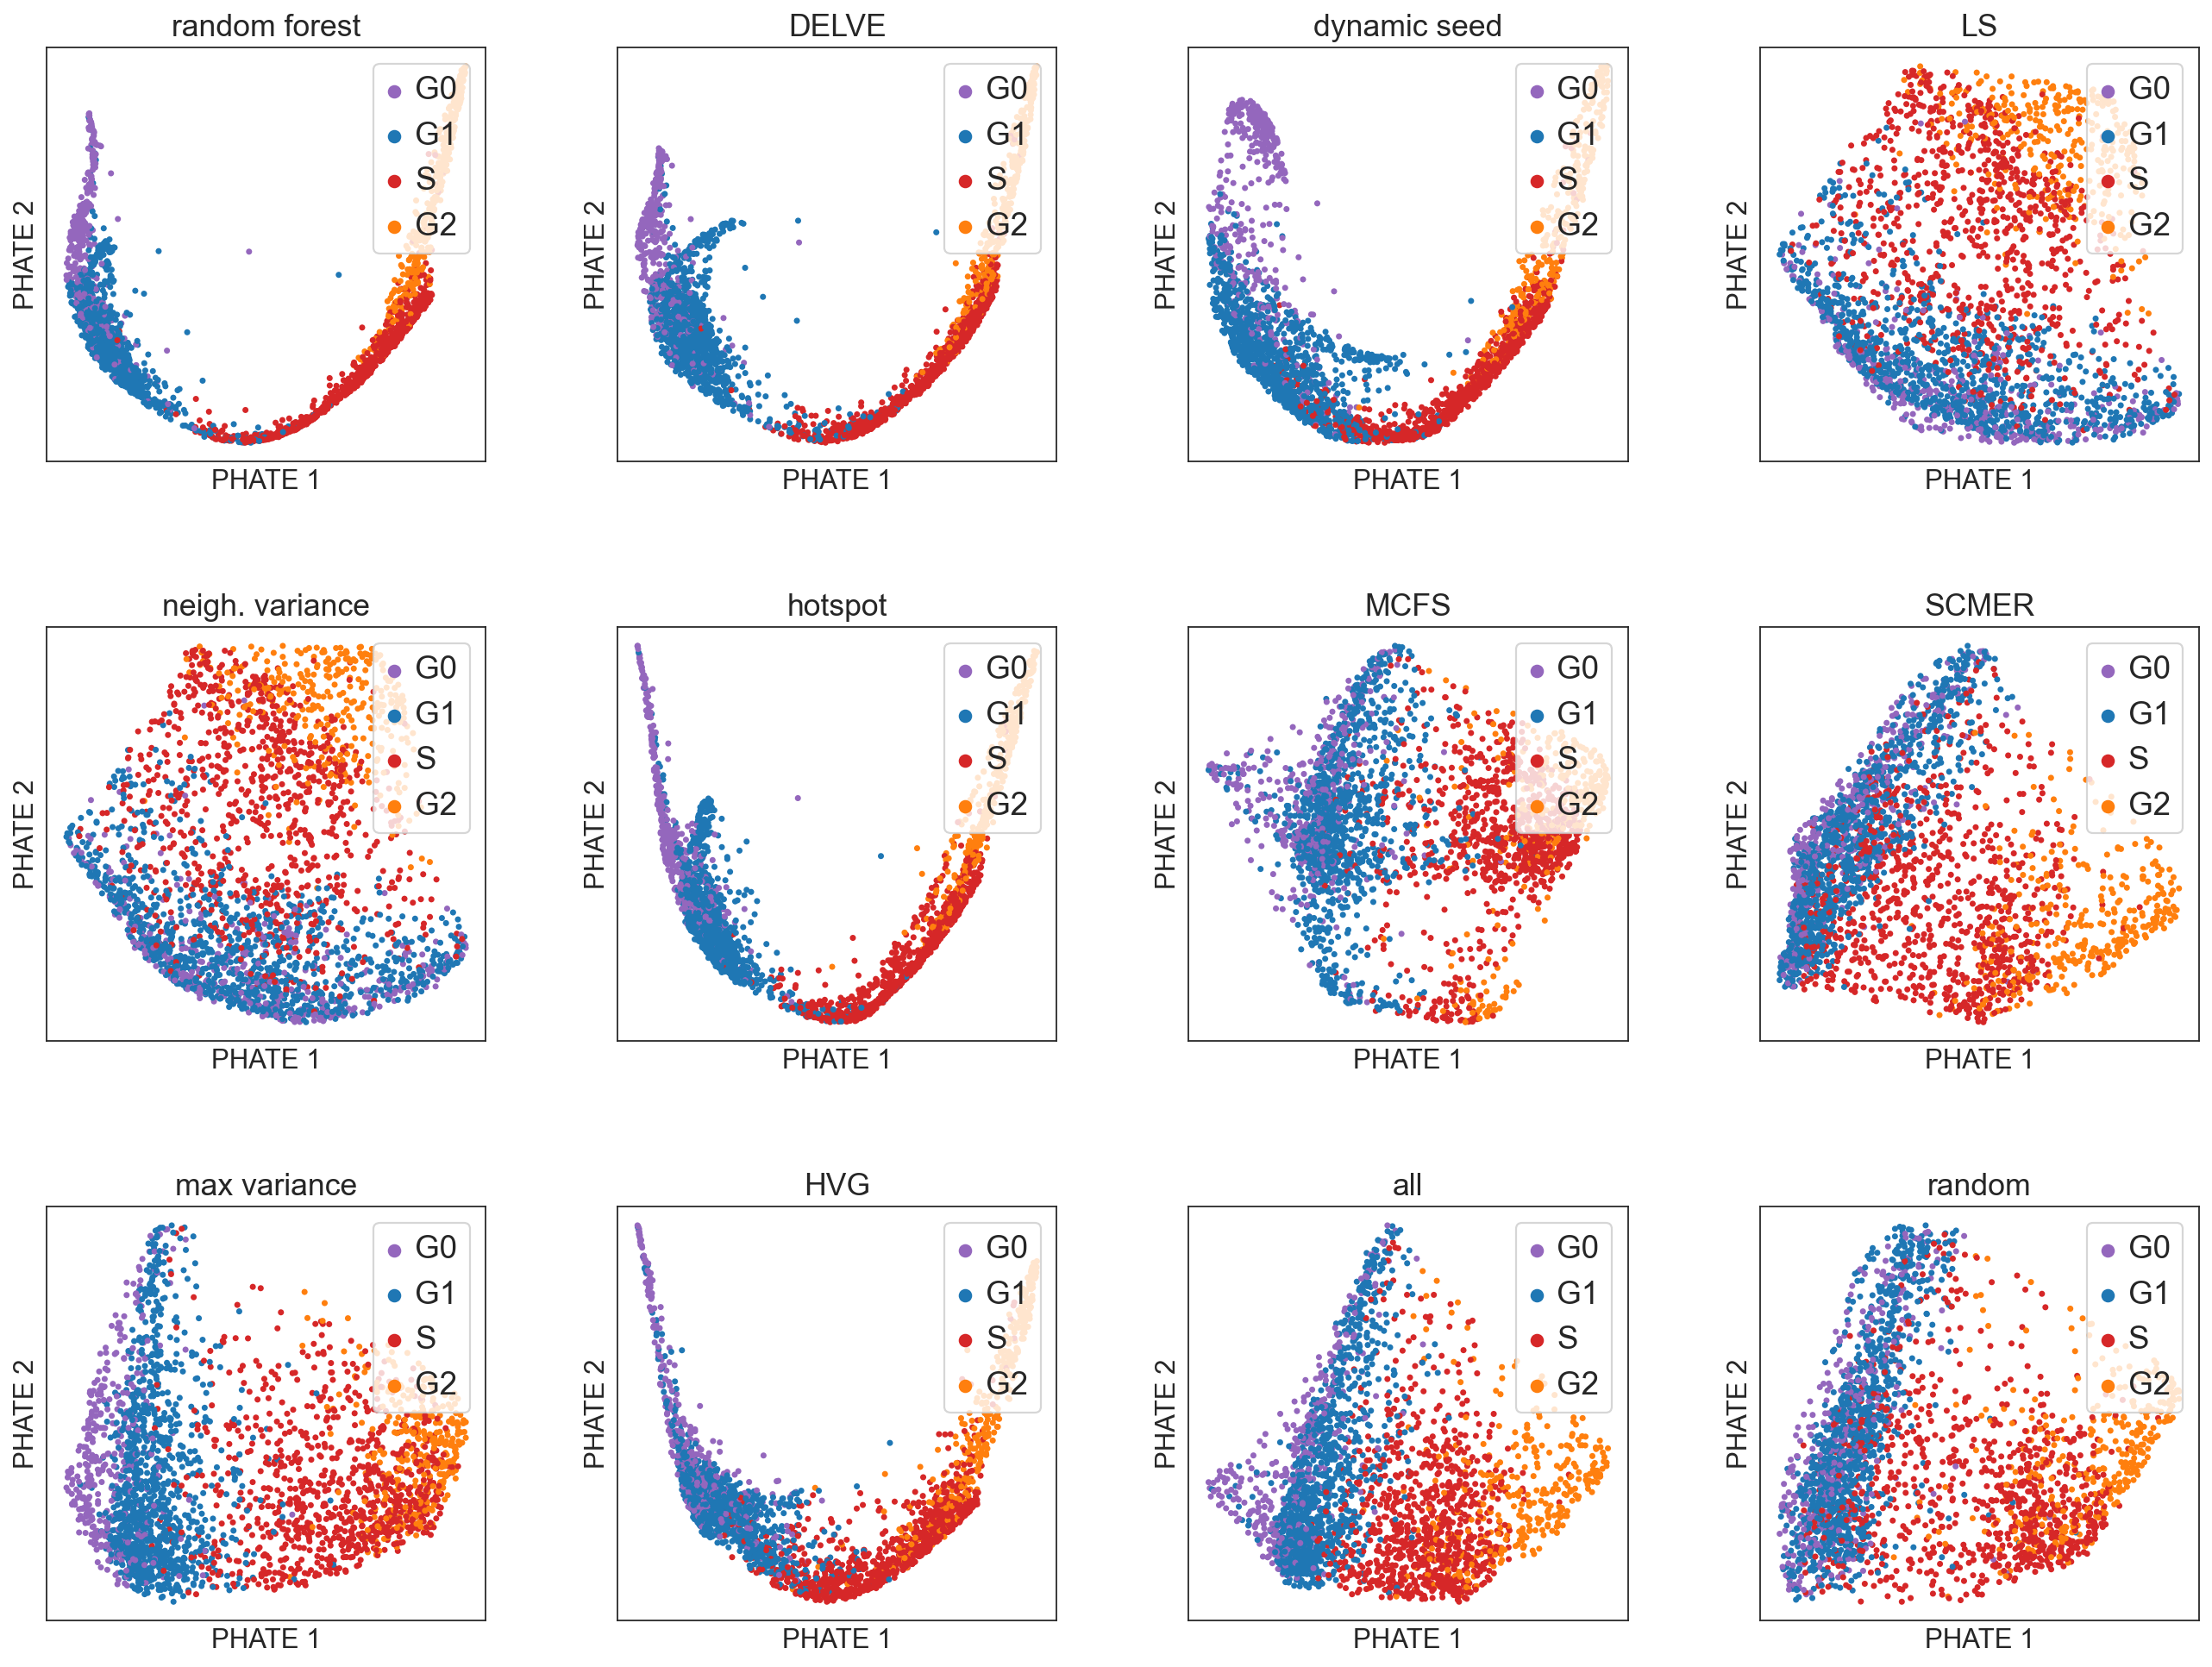

In [5]:
methods_arr = ['random_forest', f'delve_fs_trial{trial}', f'seed_features', 'laplacian_score_fs', 'neighborhood_variance_fs', 'hotspot_fs', 'mcfs_fs', 'scmer_fs', 'variance_score', 'hvg', 'all_features', f'random_features']

titles = ['random forest', 'DELVE', 'dynamic seed', 'LS', 'neigh. variance', 'hotspot', 'MCFS', 'SCMER', 'max variance', 'HVG', 'all', 'random']

colors_dict = {'G1':'tab:blue', 'S': 'tab:red', 'G2': 'tab:orange', 'M':'tab:green', 'G0': 'tab:purple'}    
hue_order = ['G0', 'G1', 'S', 'G2']           

adata_name = 'adata_RPE'

viz_directory = os.path.join('../figures', 'RPE', 'viz')
delve_benchmark.pp.make_directory(viz_directory)

delve_benchmark.pl.plot_phate(adata_directory = adata_directory, feature_directory = feature_directory, adata_name = adata_name, methods_arr = methods_arr,
                titles = titles, knn = 30, t = 10, colors_dict = colors_dict, hue_order = hue_order, subplots = [3,4], figsize = (20, 15),
                n_selected = 30, labels_key = 'phase', save_dir = viz_directory, filename_save = 'PHATE')